## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
from IPython.display import Math
import sys
import os
parent_path = os.path.abspath("..")
if parent_path not in sys.path:
    sys.path.append(parent_path)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sympy
import numpy as np
import numpy.typing as npt
import typing
from typing import Callable, Dict, List, Optional, Tuple, Union, Iterable
import qutip # type: ignore

from src.quantum_utils import measure_povm, sic_povm, mub_povm, random_rank1_povm
from src.qelm_utils import train_qelm_from_states_for_observables
from src.shadow_tomography import frame_operator
from src.utils import pp_matrix
from src import QELM

In [ ]:
def simulate_singular_values(
        n_states: int, stat: Union[int, float],
        n_realizations: int,
        povm: list[qutip.Qobj],
        resampling_states: bool = True
    ) -> npt.NDArray[np.float_]:
    # samples from the probabilities resulting from measuring n_states random pure states with the given POVM
    # and computes the singular values of the resulting frequencies matrix.
    # It does this for n_realizations times and returns the list of singular values as a numpy matrix.
    sv_data = np.zeros((n_realizations, len(povm)), dtype=float)
    # sample the training states
    random_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(n_states)]
    for idx in range(n_realizations):
        if resampling_states:
            # sample the training states
            random_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(n_states)]
        # measure the POVM on the training states with the given training stat
        frequencies = measure_povm(random_states, povm, statistics=stat, return_frequencies=True)
        # compute singular values of the frequencies matrix
        singular_values = np.linalg.svd(frequencies, compute_uv=False)
        sv_data[idx] = singular_values
    return sv_data

def hist_sampled_singular_values_rndstates(
    povm: list[qutip.Qobj],
    n_states: int, statistic_per_state: int, n_realizations: int,
    povm_label: str,
    show_individual_histograms: bool = False,
    resampling_states: bool = True
) -> None:
    """
    Plot the histogram of the sampled training singular values for each POVM element."
    """
    sv_data = simulate_singular_values(n_states, statistic_per_state, n_realizations, povm, resampling_states)
    # plot the singular values as a histogram all in the same figure
    colors = [matplotlib.colormaps['viridis'](i) for i in np.linspace(0, 1, len(povm))]
    plt.figure()
    plt.grid(True, alpha=0.3)
    for col_idx, c in enumerate(colors):
        plt.hist(sv_data[:, col_idx], bins=20, alpha=0.5, color=c, label=f'Singular value {col_idx+1}', density=True)
    plt.legend()
    plt.ylabel('Density')
    plt.title("n_states={}, $N_{{\\rm train}}$={}, n_realizations={}, POVM={}\nresampling states={}".format(
        n_states, statistic_per_state, n_realizations, povm_label, resampling_states))
    plt.show()
    # plot the columns of sv_data as separate histograms in a single row
    if show_individual_histograms:
        plt.figure(figsize=(4 * len(povm), 4))
        for i, row_idx in enumerate(range(len(povm)-1, -1, -1)):
            plt.subplot(1, len(povm), i + 1)
            plt.grid(True, alpha=0.3)
            plt.hist(sv_data[:, row_idx], bins=20, alpha=0.6, density=True)
            plt.ylabel('Density')
            plt.title('{}th singular value'.format(row_idx + 1))

        plt.tight_layout()
        plt.show()


def compute_singular_value_statistics_changing_nstates(
    povm: List[qutip.Qobj],
    n_states_list: Iterable[int],
    statistic_per_state: Union[int, float],
    n_realizations: int,
    resampling_states: bool = True,
    quantiles: List[float] = [0.01, 0.99]
) -> Dict[str, np.ndarray]:
    """
    Compute the singular value statistics for a given POVM and a number of training states.
    Returns a dictionary with the singular values and their statistics.
    """
    all_medians = []
    all_q1 = []
    all_q3 = []
    for n_states in n_states_list:
        sv_data = simulate_singular_values(n_states, statistic_per_state, n_realizations, povm, resampling_states)
        # Calculate median and quantiles for each realization
        all_medians.append(np.median(sv_data, axis=0))
        all_q1.append(np.quantile(sv_data, quantiles[0], axis=0))
        all_q3.append(np.quantile(sv_data, quantiles[1], axis=0))

    all_medians = np.stack(all_medians)
    all_q1 = np.stack(all_q1)
    all_q3 = np.stack(all_q3)
    return {
        'n_states': np.array(n_states_list),
        'medians': all_medians,
        'q1': all_q1,
        'q3': all_q3
    }


def fit_sqrt_and_return_dict(xvalues, yvalues):
    from scipy.optimize import curve_fit
    def sqrt_func(x, a):
        return a * np.sqrt(x)
    popt, pcov = curve_fit(sqrt_func, xvalues, yvalues)
    x_fit = np.linspace(min(xvalues), max(xvalues), 100)
    y_fit = sqrt_func(x_fit, *popt)
    return {'x_fit': x_fit, 'y_fit': y_fit, 'params': popt, 'cov': pcov}

def plot_singular_value_statistics_vs_nstates(
    povm: list[qutip.Qobj],
    n_states_list: Iterable[int],
    statistic_per_state: Union[int, float],
    n_realizations: int,
    povm_label: str,
    resampling_states: bool = True,
    quantiles: List[float] = [0.01, 0.99],
    add_fit: bool = False
) -> None:
    data = compute_singular_value_statistics_changing_nstates(
        povm, n_states_list, statistic_per_state, n_realizations, resampling_states, quantiles
    )
    lower_errors = data['medians'] - data['q1']
    upper_errors = data['q3'] - data['medians']

    num_singular_values = data['medians'].shape[1] # Get number of SVs from data shape
    colors = matplotlib.colormaps['viridis'](np.linspace(0, 1, num_singular_values))

    if num_singular_values >  6:
        # if there's more than 6 singular values, just plot the first 6 and print a warning
        print(f"Warning: Only plotting the first 6 singular values out of {num_singular_values}.")
        num_singular_values = 6
    # Loop through each singular value (columns in the stacked arrays)
    for sv_idx in range(num_singular_values):

        plt.errorbar(
            data['n_states'],
            data['medians'][:, sv_idx], # Median for this specific SV index across all n_states
            yerr=[lower_errors[:, sv_idx], upper_errors[:, sv_idx]],
            fmt=('o' if add_fit else '-o'), # Use lines and markers
            capsize=5, # Add caps to error bars for clarity
            color=colors[sv_idx],
            label=(f'Singular value {sv_idx + 1}' if not add_fit else ''),
            zorder=num_singular_values - sv_idx + 1 # Plot lines on top of shading
        )

        # Add the shaded region (Q1 to Q3)
        plt.fill_between(
            data['n_states'],
            data['q1'][:, sv_idx],     # Lower bound (Q1)
            data['q3'][:, sv_idx],     # Upper bound (Q3)
            color=colors[sv_idx],     # Match line color
            alpha=0.2,                # Make it semi-transparent
            zorder=num_singular_values - sv_idx # Plot shading behind lines
            # No label needed here, the errorbar line has the label
        )

        if add_fit:
            # Fit the square root function to the median singular values
            fit_results = fit_sqrt_and_return_dict(data['n_states'], data['medians'][:, sv_idx])
            plt.plot(
                fit_results['x_fit'],
                fit_results['y_fit'],
                linestyle='--',
                color=colors[sv_idx],
                label=f'Fit SV {sv_idx + 1}: a = {fit_results['params'][0]:.4f}'
            )

    # Add labels, title, legend
    # Simplified title, using f-string for easier formatting
    title = (f"Median Singular Values vs. Number of Training States\n"
             f"$N_{{shots/state}}$={statistic_per_state}, $N_{{realizations}}$={n_realizations}, "
             f"POVM={povm_label}\nresampling_states={resampling_states}")
    plt.title(title)
    plt.grid(True, alpha=0.3) # Add grid for better readability
    plt.xlabel('$N_{states}$')
    plt.ylabel('Median Singular Value')
    plt.legend()
    plt.xticks(n_states_list) # Set ticks specifically at the tested values
    plt.ylim(bottom=0) # Singular values are non-negative
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot

# Singular values vs training states

We can see pretty clearly that the singular values increase with the number of training states as $\alpha \log n$

## SIC-POVM

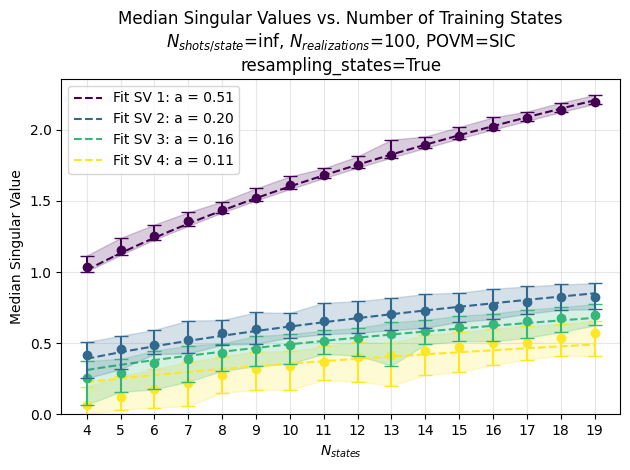

In [41]:
plot_singular_value_statistics_vs_nstates(
    povm=sic_povm(),
    n_states_list=range(4, 20),
    statistic_per_state=np.inf, n_realizations=100,
    povm_label='SIC', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

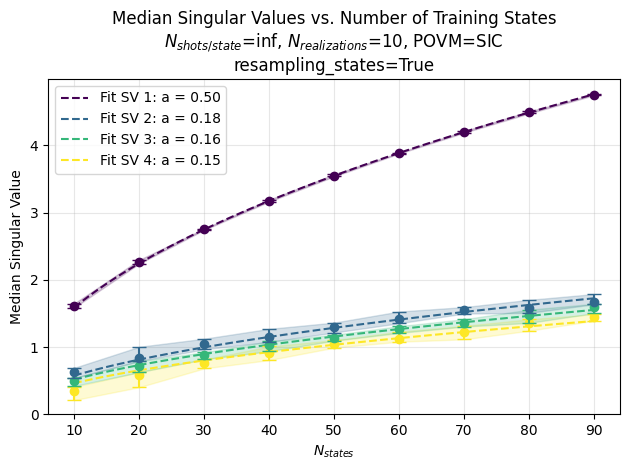

In [42]:
plot_singular_value_statistics_vs_nstates(
    povm=sic_povm(),
    n_states_list=range(10, 100, 10),
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='SIC', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

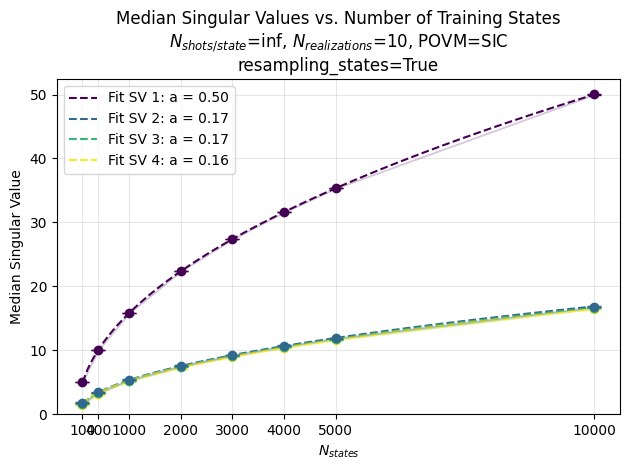

In [44]:
plot_singular_value_statistics_vs_nstates(
    povm=sic_povm(),
    n_states_list=[100, 400, 1000, 2000, 3000, 4000, 5000, 10000],
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='SIC', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

## Toy example

Eigenvalues of the matrix built from the overlaps of random pure states:

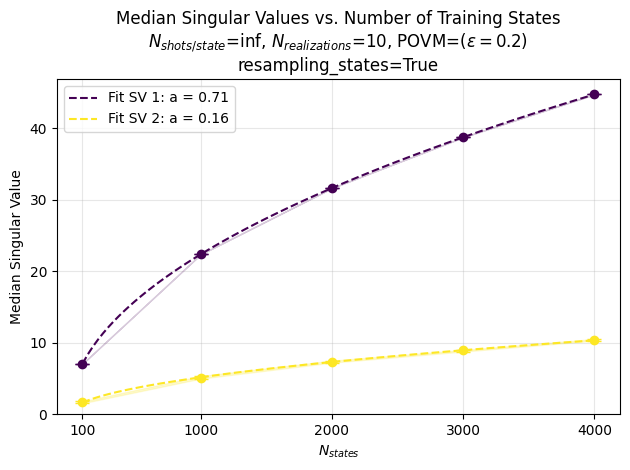

array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.16]])

In [ ]:
def degpovm(epsilon):
    return [qutip.qeye(2) * 0.5 + epsilon * qutip.sigmaz(), qutip.qeye(2) * 0.5 - epsilon * qutip.sigmaz()]

plot_singular_value_statistics_vs_nstates(
    povm=degpovm(0.2),
    n_states_list=[100, 1000, 2000, 3000, 4000],
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='$(\\epsilon=0.2)$', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

frame_operator(degpovm, basis='pauli', rescaling='none').real

## Random POVMs

In [ ]:
import scipy.linalg

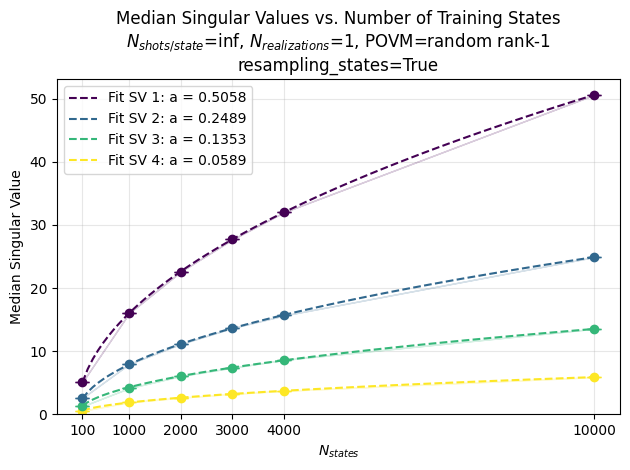

Eigenvalues of F: [0.52376306 0.36445252 0.10989046 0.02078915]
Fit a from first singular value: 0.5117436171585267
Fit a from other singular values: [0.2464591  0.13533321 0.05886304]


In [20]:
random_povm = random_rank1_povm(dim=2, num_outcomes=4)
plot_singular_value_statistics_vs_nstates(
    povm=random_povm,
    n_states_list=[100, 1000, 2000, 3000, 4000, 10000],
    statistic_per_state=np.inf, n_realizations=1,
    povm_label='random rank-1', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)
eigenvalues_frameop = np.linalg.eigvals(frame_operator(random_povm, basis='pauli', rescaling='none').real)
print('Eigenvalues of F: {}'.format(eigenvalues_frameop))
print('Fit a from first singular value: {}'.format(np.sqrt(eigenvalues_frameop[0] * 3 / 6)))
print('Fit a from other singular values: {}'.format(np.sqrt(eigenvalues_frameop[1:] / 6)))

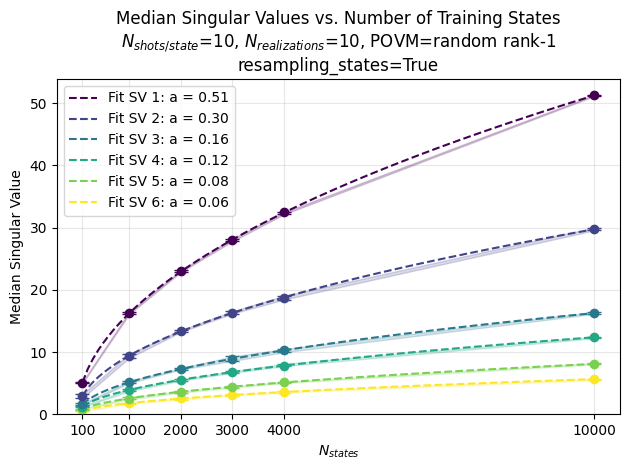

array([0.56336746, 0.36072014, 0.06296267, 0.02296456])

In [3]:
random_povm = random_rank1_povm(dim=2, num_outcomes=6)
plot_singular_value_statistics_vs_nstates(
    povm=random_povm,
    n_states_list=[100, 1000, 2000, 3000, 4000, 10000],
    statistic_per_state=10, n_realizations=10,
    povm_label='random rank-1', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

# frame_operator(random_povm, basis='pauli', rescaling='none').real
np.linalg.eigvals(frame_operator(random_povm, basis='pauli', rescaling='none').real)

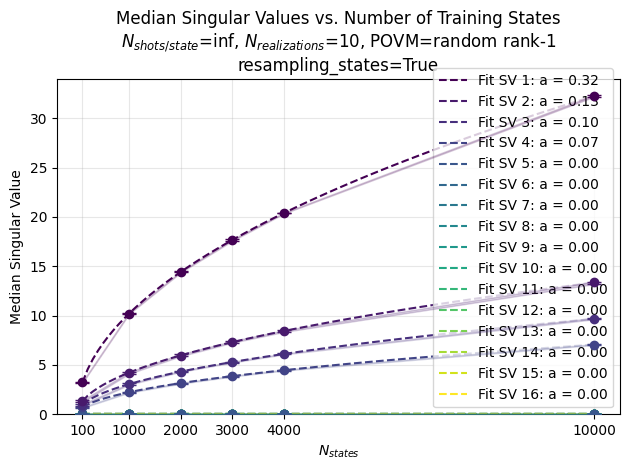

array([0.22203861, 0.10085968, 0.0557938 , 0.03009843])

In [4]:
random_povm = random_rank1_povm(dim=2, num_outcomes=16)
plot_singular_value_statistics_vs_nstates(
    povm=random_povm,
    n_states_list=[100, 1000, 2000, 3000, 4000, 10000],
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='random rank-1', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

# frame_operator(random_povm, basis='pauli', rescaling='none').real
np.linalg.eigvals(frame_operator(random_povm, basis='pauli', rescaling='none').real)

## MUBs

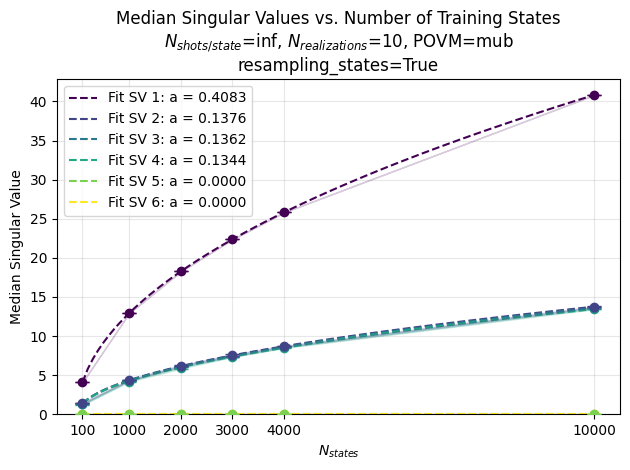

In [3]:
plot_singular_value_statistics_vs_nstates(
    povm=mub_povm(),
    n_states_list=[100, 1000, 2000, 3000, 4000, 10000],
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='mub', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

In [ ]:
qutip.Qobj(frame_operator(mub_povm(), basis='pauli', rescaling='none'))

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.33333333 0.         0.         0.        ]
 [0.         0.11111111 0.         0.        ]
 [0.         0.         0.11111111 0.        ]
 [0.         0.         0.         0.11111111]]

In [ ]:
import shadow_tomography

print(np.linalg.svd(shadow_tomography.vectorize_density_matrix(sic_povm(), basis='pauli'), compute_uv=False)**2)
print(np.linalg.svd(shadow_tomography.vectorize_density_matrix(degpovm(0.1), basis='pauli'), compute_uv=False)**2)
print(np.linalg.svd(shadow_tomography.vectorize_density_matrix(degpovm(0.2), basis='pauli'), compute_uv=False)**2)
print(np.linalg.svd(shadow_tomography.vectorize_density_matrix(degpovm(0.3), basis='pauli'), compute_uv=False)**2)

[0.5        0.16666667 0.16666667 0.16666667]
[1.   0.04]
[1.   0.16]
[1.   0.36]


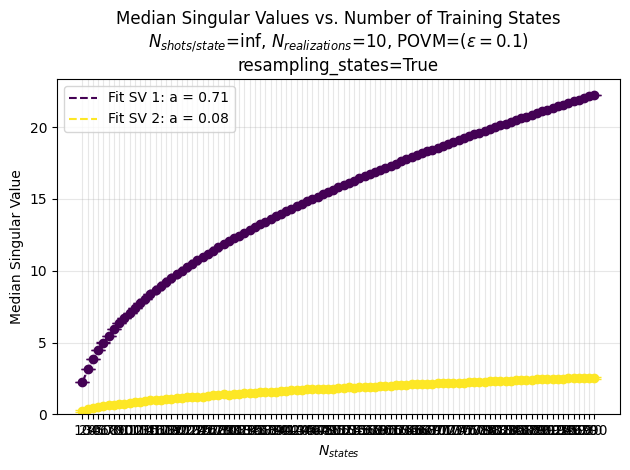

In [48]:
epsilon = 0.1
degpovm = [qutip.qeye(2) * 0.5 + epsilon * qutip.sigmaz(), qutip.qeye(2) * 0.5 - epsilon * qutip.sigmaz()]
plot_singular_value_statistics_vs_nstates(
    povm=degpovm,
    n_states_list=range(10, 1000, 10),
    statistic_per_state=np.inf, n_realizations=10,
    povm_label='$(\\epsilon=0.1)$', resampling_states=True, add_fit=True, quantiles=[0.01, 0.99]
)

## Check general formula for singular values of $\langle\mu,\rho\rangle$

The singular values of $\langle\mu,\rho\rangle$ are the square roots of the eigenvalues of $F_\rho F_\mu$.

This follows from $F_\mu F_\rho = M_\mu M_\mu^T M_\rho M_\rho^T$ having the same nonzero eigenvalues as $M_\rho^T M_\mu M_\mu^T M_\rho=\langle\mu,\rho\rangle^T \langle\mu,\rho\rangle$, which are thus the squares of the singular values of $\langle\mu\,\rho\rangle$.

In [ ]:
# explicit check of formula for singular values of the product of two matrices, for MUBs
povm = mub_povm()
training_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(100)]

frameop_povm = frame_operator(povm, basis='pauli', rescaling='none').real
frameop_states = frame_operator(training_states, basis='pauli', rescaling='none').real
product = np.dot(frameop_povm, frameop_states)

probability_matrix = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
# compute the singular values of the probability matrix
sv_probabilities = np.linalg.svd(probability_matrix, compute_uv=False)
# compute the singular values of the product matrix
sv_product = np.sort(np.sqrt(np.linalg.eigvals(product)))[::-1]

print('Singular values of the probability matrix: {}'.format(np.round(sv_probabilities, 4)))
print('Singular values of the product matrix: {}'.format(np.round(sv_product, 4)))

Singular values of the probability matrix: [4.0902 1.5283 1.2968 1.2144 0.     0.    ]
Singular values of the product matrix: [4.0902 1.5283 1.2968 1.2144]


In [ ]:
# explicit check of formula for singular values of the product of two matrices, for RANDOM POVMs
povm = random_rank1_povm(dim=2, num_outcomes=6)
training_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(100)]

frameop_povm = frame_operator(povm, basis='pauli', rescaling='none').real
frameop_states = frame_operator(training_states, basis='pauli', rescaling='none').real
product = np.dot(frameop_povm, frameop_states)

probability_matrix = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
# compute the singular values of the probability matrix
sv_probabilities = np.linalg.svd(probability_matrix, compute_uv=False)

# compute the singular values of the product matrix
sv_product = np.sort(np.sqrt(np.linalg.eigvals(product)))[::-1]

print('Singular values of the probability matrix: {}'.format(np.round(sv_probabilities, 4)))
print('Singular values of the product matrix: {}'.format(np.round(sv_product, 4)))

Singular values of the probability matrix: [4.5302 2.0542 1.0284 0.6073 0.     0.    ]
Singular values of the product matrix: [4.5302 2.0542 1.0284 0.6073]


In [136]:
povm = random_rank1_povm(dim=2, num_outcomes=6)
training_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(100)]
training_states_np = np.array([state.full() for state in training_states])

frameop_povm = frame_operator(povm, basis='pauli', rescaling='none').real
frameop_states = frame_operator(training_states, basis='pauli', rescaling='none').real
product = np.dot(frameop_povm, frameop_states)

probability_matrix = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
# compute the singular values of the probability matrix
svd_probabilities = np.linalg.svd(probability_matrix, compute_uv=True)

# print(svd_probabilities[0].shape, svd_probabilities[1].shape, svd_probabilities[2].shape)
# check that we get back the original matrix
# svd_probabilities[0] @ np.diag(svd_probabilities[1]) @ svd_probabilities[2][:6] - probability_matrix
principal_states = np.einsum('ij,jkl->ikl', svd_probabilities[2][:6], training_states_np)
[display(Math(pp_matrix(np.round(state, 3)))) for state in principal_states[:4]];

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [137]:
povm = sic_povm()
training_states = [qutip.ket2dm(qutip.rand_ket(2, 1)) for _ in range(100)]
training_states_np = np.array([state.full() for state in training_states])

frameop_povm = frame_operator(povm, basis='pauli', rescaling='none').real
frameop_states = frame_operator(training_states, basis='pauli', rescaling='none').real
product = np.dot(frameop_povm, frameop_states)

probability_matrix = measure_povm(training_states, povm, statistics=np.inf, return_frequencies=True)
# compute the singular values of the probability matrix
svd_probabilities = np.linalg.svd(probability_matrix, compute_uv=True)

# print(svd_probabilities[0].shape, svd_probabilities[1].shape, svd_probabilities[2].shape)
# check that we get back the original matrix
# svd_probabilities[0] @ np.diag(svd_probabilities[1]) @ svd_probabilities[2][:6] - probability_matrix
principal_states = np.einsum('ij,jkl->ikl', svd_probabilities[2][:6], training_states_np)
[display(Math(pp_matrix(np.round(state, 3)))) for state in principal_states[:4]]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[None, None, None, None]

# Distribution of singular values

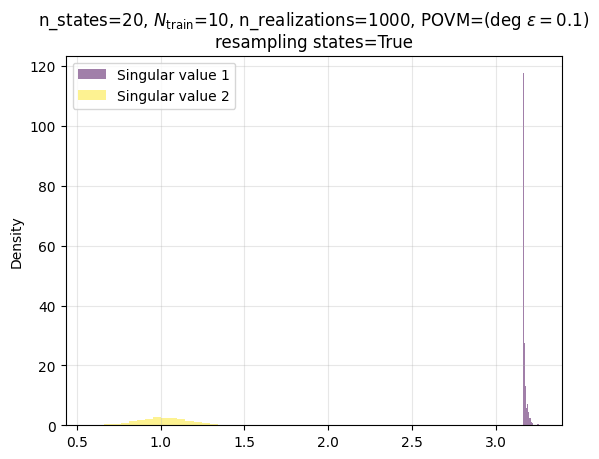

In [165]:
epsilon = 0.1
povm = [qutip.qeye(2) * 0.5 + epsilon * qutip.sigmaz(), qutip.qeye(2) * 0.5 - epsilon * qutip.sigmaz()]
hist_sampled_singular_values_rndstates(povm, n_states=20, statistic_per_state=10,
                                                 n_realizations=1000, povm_label='(deg $\\epsilon=0.1$)')

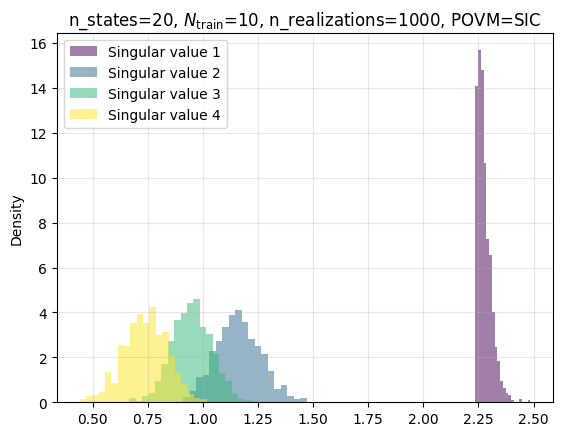

In [ ]:
hist_sampled_singular_values_rndstates(sic_povm(), 20, 10, 1000, 'SIC')

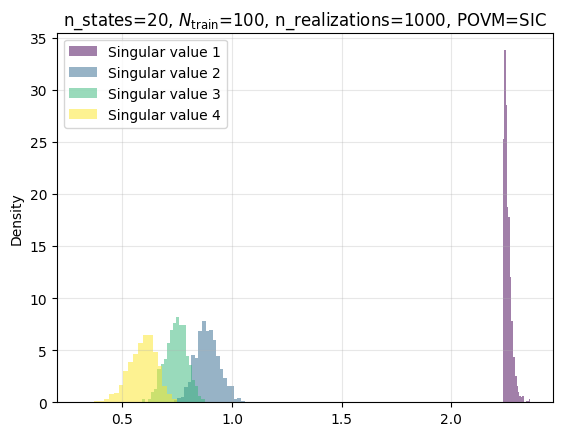

In [ ]:
hist_sampled_singular_values_rndstates(sic_povm(), 20, 100, 1000, 'SIC')

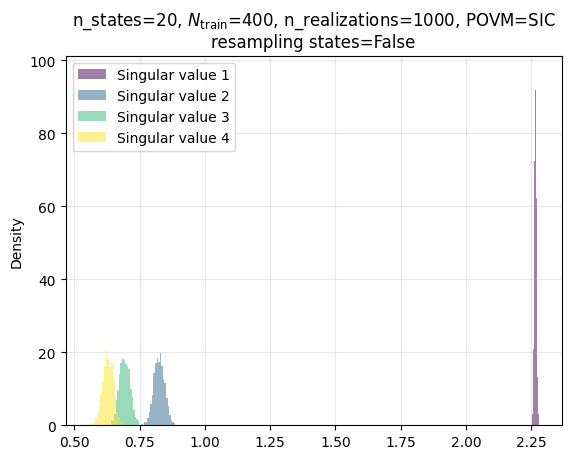

In [164]:
hist_sampled_singular_values_rndstates(sic_povm(), 20, 400, 1000, 'SIC', resampling_states=False)

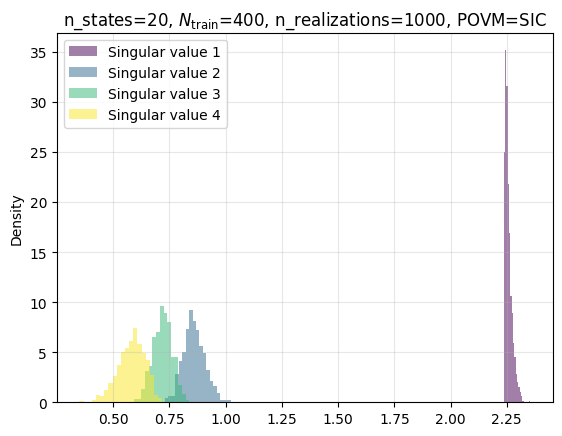

In [ ]:
hist_sampled_singular_values_rndstates(sic_povm(), 20, 400, 1000, 'SIC')

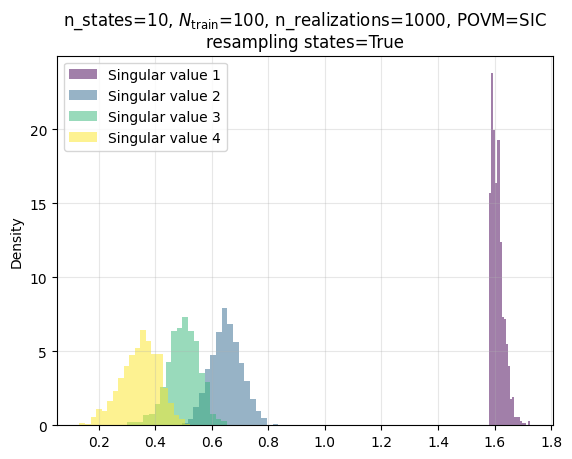

In [183]:
hist_sampled_singular_values_rndstates(sic_povm(), 10, 100, 1000, 'SIC')

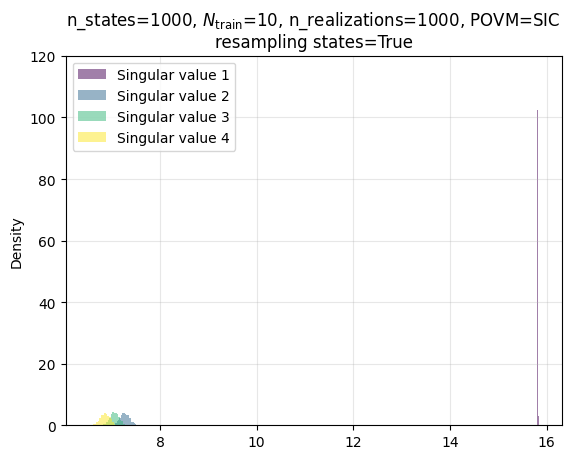

In [190]:
hist_sampled_singular_values_rndstates(sic_povm(), 1000, 10, 1000, 'SIC')

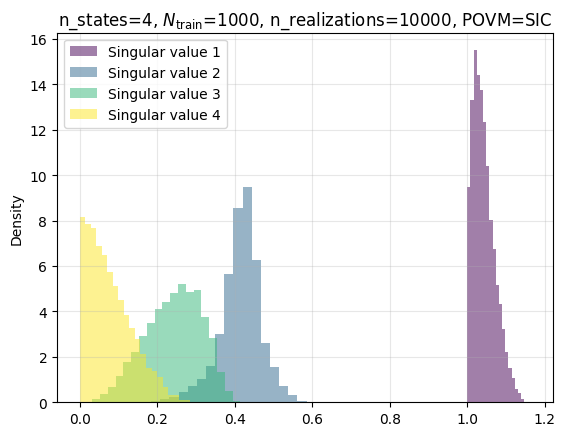

In [ ]:
hist_sampled_singular_values_rndstates(sic_povm(), 4, 1000, 10000, 'SIC')

# Singular values of stacked matrices

Trying to understand how the singular values change when adding states to a probability matrix.

Consider for simplicity some matrix $P$, with its singular values, and consider the singular values obtained stacking a bunch of $P$ one on top of the other. The singular values will then scale as the square root of the number of stacked matrices.

Indeed, observe that $\begin{pmatrix} A&A\end{pmatrix}\begin{pmatrix}\mathbf v\\\mathbf v\end{pmatrix}=2A\mathbf v$. Furthermore, the largest singular value of a matrix $M$ is the max of $\|M \mathbf v\|$ among all *unit-norm* $\mathbf v$. Therefore the max of $\|(A,A)\mathbf w\|$ will be achieved using $\mathbf w=\frac1{\sqrt2}\binom{\mathbf v}{\mathbf v}$ with $\mathbf v$ the vector giving the max singular value of $A$. Hence
$$s_{\rm max}((A,A))=\sqrt2 s_{\rm max}(A).$$
Identical reasoning applies stacking more than 2 matrices. And stacking vertically has the same effect because singular values are invariant under transposition.

For the other singular values of stacked matrices, observe that the principal components of $(A,A)$ will all have to be of the form $(\mathbf v_i,\mathbf v_i)$ with $\mathbf v_i$ principal components of $A$, hence the same reasoning applies.

Here's the numerical demo:

Singular values of the original matrix:  [2.27859423 0.75051711 0.52033305 0.14111768]
Singular value 0. Fitted parameters: a = 2.278594227750499
Singular value 1. Fitted parameters: a = 0.7505171074808468
Singular value 2. Fitted parameters: a = 0.5203330496239423
Singular value 3. Fitted parameters: a = 0.14111767615857929


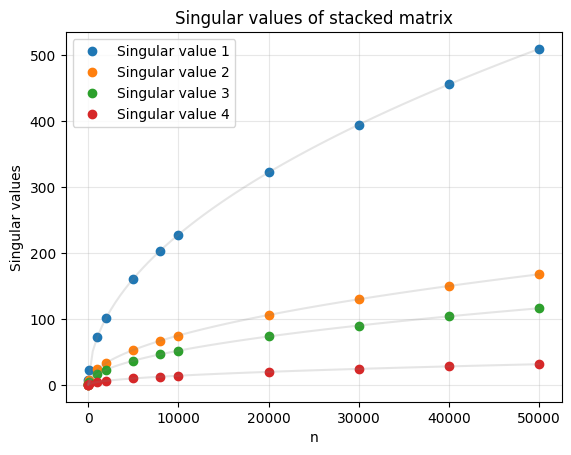

In [265]:
from scipy.optimize import curve_fit
def sqrt_func(x, a):
    return a * np.sqrt(x)

matrix_P = np.random.rand(4, 4)
list_of_n = [1, 10, 100, 1000, 2000, 5000, 8000, 10000, 20000, 30000, 40000, 50000]
singular_values = np.zeros((len(list_of_n), matrix_P.shape[0]), dtype=float)
# print the starting singular values of the matrix
print("Singular values of the original matrix: ", np.linalg.svd(matrix_P, compute_uv=False))
for idx in range(len(list_of_n)):
    # stack a bunch of copies of the same matrix on top of each other. Result should be a single matrix
    stacked_matrix = np.vstack([matrix_P] * list_of_n[idx])
    singular_values[idx] = np.linalg.svd(stacked_matrix, compute_uv=False)
# === plot the singular values ===
plt.figure()
plt.grid(True, alpha=0.3)
plt.plot(list_of_n, singular_values, marker='o', linestyle='')
plt.xlabel('n')
plt.ylabel('Singular values')
plt.title('Singular values of stacked matrix')
plt.legend([f'Singular value {i + 1}' for i in range(stacked_matrix.shape[1])])
# plot the fitted curve for each singular value
for col_idx in range(singular_values.shape[1]):
    popt, pcov = curve_fit(sqrt_func, list_of_n, singular_values[:, col_idx])
    print("Singular value {}. Fitted parameters: a = {}".format(col_idx, *popt))
    x_fit = np.linspace(min(list_of_n), max(list_of_n), 100)
    y_fit = sqrt_func(x_fit, *popt)
    plt.plot(x_fit, y_fit, '-', color='gray', label='Fitted sqrt', alpha=0.2)
plt.show()
